In [1]:
# original library
from flex_tools import *

import numpy as np
import numpy.linalg as la
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns

import gc
import sys
import time
from tqdm import tqdm
import mpi4py

from typing import Union, Optional, Callable
from dataclasses import dataclass
from IPython.display import display

In [2]:
# FLEX_pipeline は、flextools の中にあるものを使用してもよいが、mu の探索範囲や mix_rate を変化させるなどのカスタマイズをすると効率的な計算が可能。
def FLEX_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu_init, pm, mix_rate, N_flexiter=1000, tol_flex=1e-3, mask=None):
    mu = mu_init
    SIGMA_tmp = None
    if mask is not None:
        U_charge = mask.apply_mask(U_charge)
        U_spin = mask.apply_mask(U_spin)
    for i in range(N_flexiter):
        G = calc_Green(SIGMA_tmp, ENERGY, mu, *pm.calc_Green())
        G_tau_r = from_iwn_k_to_tau_r(G)
        CHI0_tau_r = calc_chi0_tau_r(G_tau_r)
        if mask is not None:
            CHI0_tau_r = mask.apply_mask(CHI0_tau_r)
        CHI0, CHI_charge, CHI_spin = \
            calc_Susceptibilities(CHI0_tau_r, U_charge, U_spin, *pm.calc_Susceptibilities())
        V_Sigma = calc_V_effective(U_charge, U_spin, CHI0, CHI_charge, CHI_spin)
        V_Sigma_tau_r = from_iwn_k_to_tau_r(V_Sigma)
        if mask is not None:
            V_Sigma_tau_r = mask.restore(V_Sigma_tau_r)
        SIGMA = calc_Self_Energy(V_Sigma_tau_r, G_tau_r, *pm.calc_Self_Energy())
        # 収束の判定
        err = eval_Self_Energy_err(SIGMA, SIGMA_tmp)
        if err < tol_flex:
            SIGMA = mix_Self_Energy(SIGMA, SIGMA_tmp, 0.5)
            mu = calc_mu(SIGMA, ENERGY, ENERGY_DIAG, *pm.calc_mu(), mu_init=mu)
            G = calc_Green(SIGMA, ENERGY, mu, *pm.calc_Green())
            return CHI0, CHI_charge, CHI_spin, SIGMA, mu, G
        else:
            print('err={:.4g}'.format(err))
            SIGMA_tmp = mix_Self_Energy(SIGMA, SIGMA_tmp, mix_rate)
            if i < 2/mix_rate:
                mu = calc_mu(SIGMA_tmp, ENERGY, ENERGY_DIAG, *pm.calc_mu(), search_min=mu-1, search_max=mu+1, solver='brent')
            else:
                try:
                    mu = calc_mu(SIGMA_tmp, ENERGY, ENERGY_DIAG, *pm.calc_mu(), mu_init=mu)
                except:
                    mu = calc_mu(SIGMA_tmp, ENERGY, ENERGY_DIAG, *pm.calc_mu(), search_min=mu-1, search_max=mu+1, solver='brent')
    print('Waring: Self Energy is not converge!  err={:.4g}'.format(err))
    G = calc_Green(SIGMA_tmp, ENERGY, mu, *pm.calc_Green())
    return CHI0, CHI_charge, CHI_spin, SIGMA, mu, G

### 2次元2サイト2軌道  ( 2層系, U=4 )

In [3]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 256
Nrvec = 5

Nsite = 2
Norbit_each_site = (1,1)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 4.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,2.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [4]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mask = mkmask(U_charge, U_spin)
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    FLEX_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm, mix_rate=0.2, mask=mask)
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

chemical potential = -0.5174
err=inf
err=267.6
err=27.45
err=18.02
err=97.16
err=3.576
err=1.869
err=4.436
err=9.816
err=6.238
err=4.264
err=22.02
err=2.708
err=4.669
err=12.66
err=3.88
err=1.782
err=1.056
err=0.7006
err=0.495
err=0.4021
err=0.351
err=0.3026
err=0.2582
err=0.2182
err=0.1831
err=0.1526
err=0.1266
err=0.1046
err=0.08619
err=0.07081
err=0.05805
err=0.0475
err=0.03882
err=0.03168
err=0.02589
err=0.02132
err=0.01753
err=0.01441
err=0.01183
err=0.009699
err=0.007949
err=0.006512
err=0.005332
err=0.004365
err=0.003572
err=0.002923
err=0.002393
err=0.001958
err=0.001604
err=0.001314
err=0.001077
chi0= 0.1446501955242917
chi_S= 1.2400577706549123
chi_C= 0.08485510319373057
Sigma= 0.5011196841696874
chemical potential = -0.59029
G= 1.8174195454461293


lambda= 0.7312631367232529


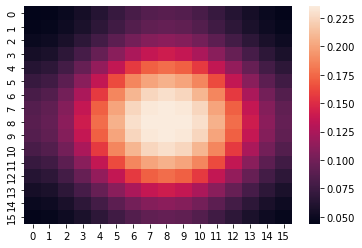

lambda= 0.2100977320104879


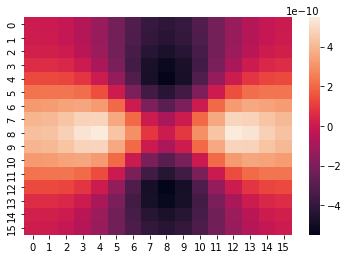

lambda= 0.18620786114731064


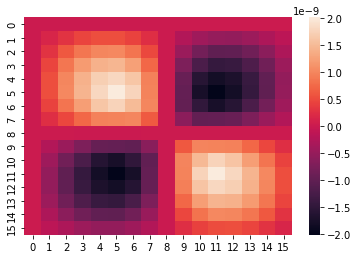

In [5]:
DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask, k=3)
print('lambda=', lambda_list[0])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[0], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()
print('lambda=', lambda_list[1])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[1], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()
print('lambda=', lambda_list[2])
sns.heatmap(np.sum(np.imag(from_orbit_to_band(DELTA_list[2], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()

### 2次元2サイト2軌道  ( 2層系, U=6 )

In [6]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 256
Nrvec = 5

Nsite = 2
Norbit_each_site = (1,1)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.1
band_filling = 0.9
Uinner = 6.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,2.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [7]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mask = mkmask(U_charge, U_spin)
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    FLEX_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm, mix_rate=0.1, mask=mask)
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

chemical potential = -0.4772
err=inf
err=1.305e+04
err=23.78
err=12.75
err=703.5
err=10.78
err=5.734
err=3.612
err=4.425
err=5.665
err=5.973
err=6.527
err=6.957
err=13.57
err=9.555
err=4.52
err=3.48
err=6.955
err=30.27
err=2.686
err=2.746
err=2.484
err=5.469
err=1.653
err=1.475
err=1.169
err=65.14
err=6.113
err=3.837
err=3.501
err=4.054
err=4.462
err=4.144
err=3.239
err=2.378
err=1.743
err=1.395
err=1.363
err=1.314
err=1.247
err=2.506
err=1.186
err=4.199
err=15.42
err=19.52
err=47.08
err=26.35
err=8.761
err=20.06
err=13.51
err=17.23
err=10.5
err=9.03
err=8.419
err=5.02
err=3.164
err=2.335
err=1.782
err=1.399
err=1.125
err=0.9223
err=0.7797
err=0.6723
err=0.581
err=0.5036
err=0.4405
err=0.3893
err=0.3448
err=0.3059
err=0.272
err=0.2423
err=0.2162
err=0.1932
err=0.1729
err=0.155
err=0.1391
err=0.125
err=0.1124
err=0.1013
err=0.09127
err=0.08235
err=0.07436
err=0.0672
err=0.06078
err=0.05501
err=0.04982
err=0.04516
err=0.04096
err=0.03814
err=0.0358
err=0.0336
err=0.03154
err=0.02961
err=

lambda= 0.9330413160109651


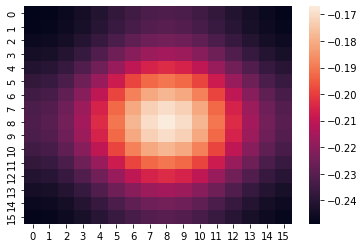

lambda= 0.2210816312155107


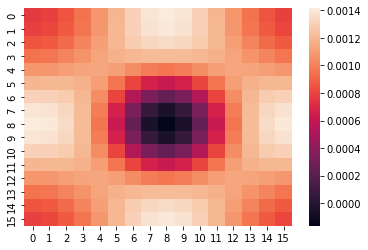

lambda= 0.41719240643271976


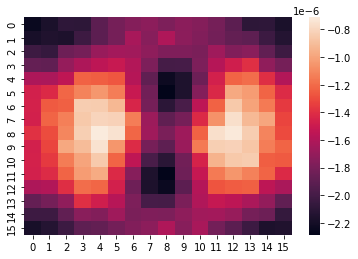

lambda= 0.13995596133195212


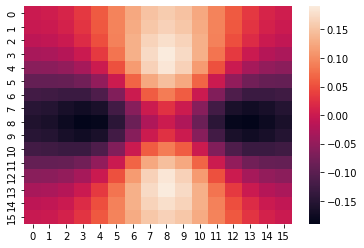

lambda= 0.12488265614622686


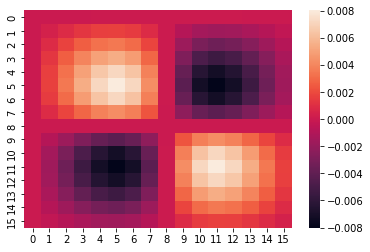

lambda= 0.11416630731527146


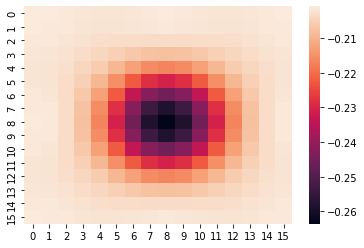

In [8]:
DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask, k=6, symmetrize='auto')
for i in range(6):
    print('lambda=', lambda_list[i])
    sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[i], UNITARY)), axis=0)[:,:,0,0,0])
    plt.show()

lambda= 0.12488275636179919


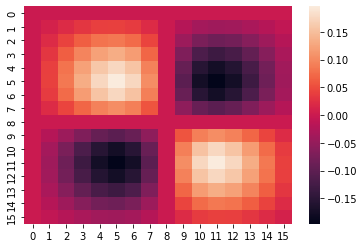

In [9]:
DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask, k=1, symmetrize='dxy')
print('lambda=', lambda_list[0])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[0], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()

lambda= 0.1399562024448451


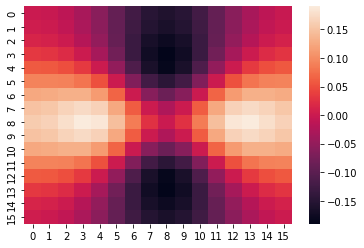

In [10]:
DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask, k=1, symmetrize='dx2-y2')
print('lambda=', lambda_list[0])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[0], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()

## Pade 近似

100%|██████████| 49/49 [00:00<00:00, 60.21it/s]


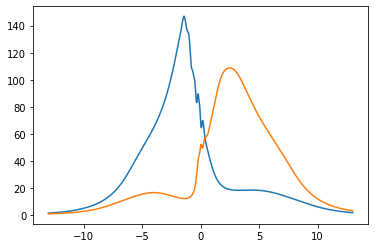

In [11]:
idelta = 0.05j
Neps = 1001
epsilon = np.linspace(-13,13,Neps)

G_band = from_orbit_to_band(G, UNITARY)
G_R = pade_approx(G_band, pm.matsubara_half, epsilon+idelta, Nm_cutoff=50)
A_spec = -np.imag(G_R)

DOS0 = np.sum(A_spec, axis=(1,2,3))[:,0,0]
DOS1 = np.sum(A_spec, axis=(1,2,3))[:,1,1]

plt.plot(np.real(epsilon), DOS0)
plt.plot(np.real(epsilon), DOS1)
plt.show()